In [1]:
import ast
import numpy as np
import pandas as pd
import pickle
import random
import string
import mglearn
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
PATHS = {
    "dataset": "data.csv",
    "feature-columns": "feature-columns.pkl",
    "image-labels": "image-labels.pkl",
    "scaler": "classifiers/scaler.pkl",
    "pca": "classifiers/pca.pkl",
    "classifier": "classifiers/rcnn-mlp.h5",
}

In [3]:
dataset = pd.read_csv(PATHS["dataset"], index_col=False)
pos = dataset[dataset["brand"].astype(int) == 1]
neg = dataset[dataset["brand"].astype(int) == 0]

In [4]:
class Features:
    
    def compute_features(self, sample):
        features = pd.DataFrame()
        features["Has_Biography"] = self._fe_has_biography(sample)
        features["Media_Count"] = sample["mediaCount"].fillna(-1)
        features["Has_City_Id"] = self._fe_has_city_id(sample)
        features["Latitude"] = sample["latitude"].fillna(-1)
        features["Longitude"] = sample["longitude"].fillna(-1)
        features["Has_Zip"] = self._fe_has_zip(sample)
        features["Has_Contact_Phone_Number"] = self._fe_has_contact_phone_number(sample)
        features["Following_Count"] = sample["followingCount"].fillna(-1)
        features["Follower_Count"] = sample["followerCount"].fillna(-1)
        features["Usertags_Count"] = sample["usertagsCount"].fillna(-1)
        features["Is_External_Url"] = self._fe_is_external_url(sample)
        features["Is_Business"] = sample["isBusiness"].fillna(-1).astype(int)
        features = pd.concat([features, self._fe_category(sample)], axis=1)
        features["Geo_Media_Count"] = sample["geoMediaCount"].fillna(-1)
        features["Shoppable_Posts_Count"] = sample["shoppablePostsCount"].fillna(-1)
        features["Following_Tag_Count"] = sample["followingTagCount"].fillna(-1)
        features["Is_Picture"] = self._fe_is_picture(sample)
        features = pd.concat([features, self._fe_image_labels(sample)], axis=1)
        features["Has_Email"] = sample["hasEmail"].astype(int)
        pickle.dump(features.columns, open(PATHS["feature-columns"], "wb"))
        return features

    @staticmethod
    def _fe_has_biography(sample):
        feature = []
        for item in sample["biography"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_has_city_id(sample):
        feature = []
        for item in sample["cityId"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature
    
    @staticmethod
    def _fe_has_zip(sample):
        feature = []
        for item in sample["zip"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_has_contact_phone_number(sample):
        feature = []
        for item in sample["contactPhoneNumber"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_is_external_url(sample):
        feature = []
        for item in sample["externalUrl"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_category(sample):
        return pd.get_dummies(sample["category"])

    @staticmethod
    def _fe_is_picture(sample):
        feature = []
        for item in sample["picture"]:
            if item == "" or pd.isnull(item):
                feature.append(0)
            else:
                feature.append(1)
        return feature

    @staticmethod
    def _fe_image_labels(sample):
        image_labels = set()
        for item in sample["imageLabels"]:
            if "nan" not in item:
                labels = ast.literal_eval(item[1:][:-1])
                if "((" in str(labels):
                    for label in labels:
                        image_labels.add(label[0])
                else:
                    label = labels
                    image_labels.add(label[0])
        image_labels.add("nan")
        pickle.dump(image_labels, open(PATHS["image-labels"], "wb"))
        image_labels_df = pd.DataFrame(columns=image_labels)
        for item in sample["imageLabels"]:
            image_labels_df.loc[len(image_labels_df)] = 0
            if "nan" not in item:
                labels = ast.literal_eval(item[1:][:-1])
                if "((" in str(labels):
                    for label in labels:
                        val = image_labels_df.loc[image_labels_df.index[-1], label[0]]
                        image_labels_df.loc[image_labels_df.index[-1], label[0]] = max(label[1], val)
                else:
                    label = labels
                    image_labels_df.loc[image_labels_df.index[-1], label[0]] = label[1]
            else:
                image_labels_df.loc[image_labels_df.index[-1], "nan"] = 1
        return image_labels_df

    '''Tokenization'''
    @staticmethod
    def tokenize(sample, column, max_len=100):
        alphabet = (list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ["UNK", " "])
        vocab = {}
        for i, c in enumerate(alphabet):
            vocab[c] = i + 1
        items = sample[column].astype(str).str.encode("utf-8").str.decode("ascii", "ignore").values.tolist()
        tokenized = np.zeros((len(items), max_len))
        for i in range(len(items)):
            item_arr = np.zeros(max_len)
            chars = list(items[i].lower())
            for j in range(len(chars)):
                # counter should not larger than max_len
                if j >= max_len:
                    break
                if chars[j] in alphabet:
                    item_arr[j] = vocab[chars[j]]
                else:
                    item_arr[j] = max(vocab.values())
            tokenized[i, :] = item_arr
        return tokenized

    @staticmethod
    def untokenize(tokenized):
        alphabet = (list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ["UNK", " "])
        reverse_vocab = {}
        for i, c in enumerate(alphabet):
            reverse_vocab[i + 1] = c
        items = []
        for item_arr in tokenized:
            item = " ".join([reverse_vocab[i] if i > 0 else "" for i in item_arr])
            items.append(item)
        return items

In [5]:
f = Features()
features = f.compute_features(dataset)
tokenized_biography = f.tokenize(dataset, "biography", 170)
untokenized_biography = f.untokenize(tokenized_biography)
labels = dataset["brand"].astype(int)

In [6]:
(X_train,
 X_val,
 y_train,
 y_val,
 indices_train,
 indices_val) = train_test_split(features,
                                 labels,
                                 [i for i in range(len(features))],
                                 random_state=42)

In [7]:
scaler = StandardScaler().fit(X_train)
pickle.dump(scaler, open(PATHS["scaler"], "wb"))
X_scaled_train = scaler.transform(X_train)
X_scaled_val = scaler.transform(X_val)

In [8]:
pca = PCA(n_components=30).fit(X_scaled_train)
pickle.dump(pca, open(PATHS["pca"], "wb"))
X_pca_train = pd.DataFrame(data=pca.transform(X_scaled_train), columns=["PC" + str(i + 1) for i in range(30)])
X_pca_val = pd.DataFrame(data=pca.transform(X_scaled_val), columns=["PC" + str(i + 1) for i in range(30)])

In [9]:
X_token_train = np.array([tokenized_biography[i] for i in indices_train])
X_token_val = np.array([tokenized_biography[i] for i in indices_val])

In [10]:
alphabet = (list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ["UNK", " "])
vocab_size = len(alphabet)
vocab_size

70

In [11]:
embedding_weights = [] # (71, 70)
# Zero vector to represent the PAD
embedding_weights.append(np.zeros(vocab_size))
for i, c in enumerate(alphabet):
    one_hot = np.zeros(vocab_size)
    one_hot[i] = 1
    embedding_weights.append(one_hot)
embedding_weights = np.array(embedding_weights)
# First row all 0 for PAD, 69 char, last row for UNK
print(embedding_weights.shape)
embedding_weights

(71, 70)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
input_size = 170
embedding_size = 70
conv_layers = [[8, 4, 2], [8, 4, 2], [8, 4, 2]]
full_connected_layers = [8, 8]
mlp_layers = [64, 256, 128, 64]
dropout = 0.2
optimizer = "adam"
loss = "binary_crossentropy"
monitor="val_accuracy"

In [13]:
embedding_layer = Embedding(
    input_dim=vocab_size + 1,
    output_dim=embedding_size,
    input_length=input_size,
    weights=[embedding_weights])

In [14]:
rcnn_inputs = Input(shape=(input_size,), dtype="int64")
x = embedding_layer(rcnn_inputs)
x = Bidirectional(LSTM(16, recurrent_dropout=dropout, return_sequences=True))(x)
print("LSTM {}".format(x.shape))
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x)
    print("Conv1D {}".format(x.shape))
    x = Activation("relu")(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)
        print("MaxPooling1D {}".format(x.shape))
x = Flatten()(x)
print("Flatten {}".format(x.shape))
for dense_size in full_connected_layers:
    x = Dense(dense_size, activation="relu")(x)
    print("Dense {}".format(x.shape))
    x = Dropout(dropout)(x)
rcnn_outputs = x

2023-03-04 10:43:47.038739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


LSTM (None, 170, 32)
Conv1D (None, 167, 8)
MaxPooling1D (None, 83, 8)
Conv1D (None, 80, 8)
MaxPooling1D (None, 40, 8)
Conv1D (None, 37, 8)
MaxPooling1D (None, 18, 8)
Flatten (None, 144)
Dense (None, 8)
Dense (None, 8)


In [15]:
rcnn_classifier = Model(inputs=rcnn_inputs, outputs=rcnn_outputs)
rcnn_classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 170)]             0         
                                                                 
 embedding (Embedding)       (None, 170, 70)           4970      
                                                                 
 bidirectional (Bidirectiona  (None, 170, 32)          11136     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 167, 8)            1032      
                                                                 
 activation (Activation)     (None, 167, 8)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 83, 8)            0         
 )                                                           

In [16]:
mlp_inputs = Input(shape=(X_pca_train.shape[1],), name="mlp_input")
y = mlp_inputs
for dense_size in mlp_layers:
    y = Dense(dense_size, activation="relu")(y)
    print("Dense {}".format(y.shape))
    y = Dropout(dropout)(y)
mlp_outputs = y

Dense (None, 64)
Dense (None, 256)
Dense (None, 128)
Dense (None, 64)


In [17]:
mlp_classifier = Model(inputs=mlp_inputs, outputs=mlp_outputs)
mlp_classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mlp_input (InputLayer)      [(None, 30)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                1984      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0   

In [18]:
concatenated = concatenate([rcnn_outputs, mlp_outputs])
outputs = Dense(1, activation="sigmoid")(concatenated)

In [19]:
classifier = Model([rcnn_inputs, mlp_inputs], outputs)
classifier.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 170)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 170, 70)      4970        ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 170, 32)      11136       ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 167, 8)       1032        ['bidirectional[0][0]']          
                                                                                            

In [20]:
checkpoint = ModelCheckpoint(PATHS["classifier"], monitor=monitor, save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor=monitor, patience=10, restore_best_weights=True)
history = classifier.fit(
    [X_token_train, X_pca_train], y_train, epochs=100,
    validation_data=([X_token_val, X_pca_val], y_val), verbose=1, batch_size=128,
    callbacks=[early_stopping, checkpoint])

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.7003 - accuracy: 0.6636
Epoch 1: val_accuracy improved from -inf to 0.77600, saving model to classifiers/rcnn-mlp.h5
6/6 [==============================] - 6s 289ms/step - loss: 0.7003 - accuracy: 0.6636 - val_loss: 0.5675 - val_accuracy: 0.7760
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.7637
Epoch 2: val_accuracy improved from 0.77600 to 0.78400, saving model to classifiers/rcnn-mlp.h5
6/6 [==============================] - 1s 171ms/step - loss: 0.5946 - accuracy: 0.7637 - val_loss: 0.5084 - val_accuracy: 0.7840
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.7864
Epoch 3: val_accuracy improved from 0.78400 to 0.79200, saving model to classifiers/rcnn-mlp.h5
6/6 [==============================] - 1s 173ms/step - loss: 0.5416 - accuracy: 0.7864 - val_loss: 0.4819 - val_accuracy: 0.7920
Epoch 4/100
6/6 [==============================] 

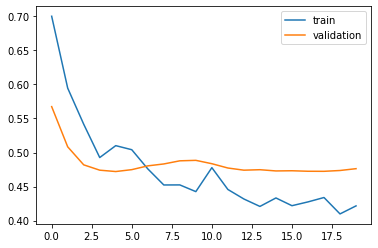

In [21]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()

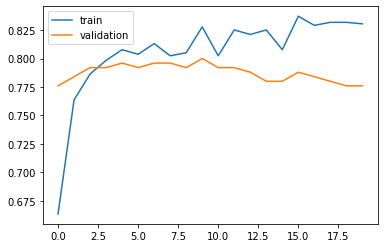

In [22]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

In [23]:
print("Accuracy on training set: {}".format(classifier.evaluate([X_token_train, X_pca_train], y_train)[1]))
print("Accuracy on validation set: {}".format(classifier.evaluate([X_token_val, X_pca_val], y_val)[1]))

24/24 [==============================] - 1s 30ms/step - loss: 0.4053 - accuracy: 0.8398
Accuracy on training set: 0.8397864103317261
8/8 [==============================] - 0s 27ms/step - loss: 0.4885 - accuracy: 0.8000
Accuracy on validation set: 0.800000011920929


8/8 [==============================] - 1s 26ms/step
Precision: 0.826
Recall: 0.826
Threshold: 0.502


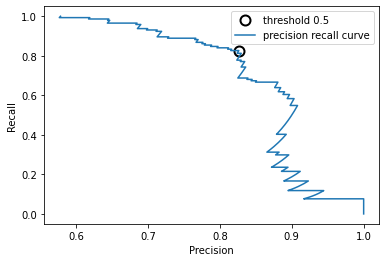

In [24]:
precision, recall, thresholds = precision_recall_curve(
    y_val, np.asarray(classifier.predict([X_token_val, X_pca_val])).reshape(-1))
close_zero = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_zero], recall[close_zero], "o", markersize=10, label="threshold 0.5", fillstyle="none",
        c="k", mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
print("Precision: {:.3f}\nRecall: {:.3f}\nThreshold: {:.3f}".format(precision[close_zero],
                                                                    recall[close_zero], thresholds[close_zero]))

8/8 [==============================] - 0s 26ms/step
TPR: 0.826
FPR: 0.236
Threshold: 0.502


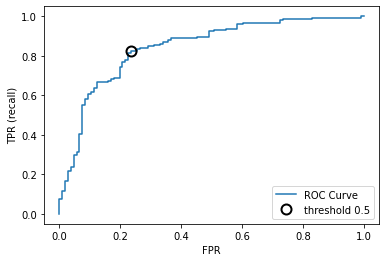

In [25]:
fpr, tpr, thresholds = roc_curve(y_val, np.asarray(classifier.predict([X_token_val, X_pca_val])).reshape(-1))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_zero], tpr[close_zero], "o", markersize=10, label="threshold 0.5", fillstyle="none", c="k", mew=2)
plt.legend(loc=4)
print("TPR: {:.3f}\nFPR: {:.3f}\nThreshold: {:.3f}".format(tpr[close_zero], fpr[close_zero], thresholds[close_zero]))

In [26]:
predictions = np.asarray(classifier.predict([X_token_val, X_pca_val])).reshape(-1) > 0.5
print(classification_report(y_val, predictions, target_names=['Not Brand', 'Brand']))

8/8 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

   Not Brand       0.76      0.76      0.76       106
       Brand       0.83      0.83      0.83       144

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250



Confusion matrix:
[[ 81  25]
 [ 25 119]]


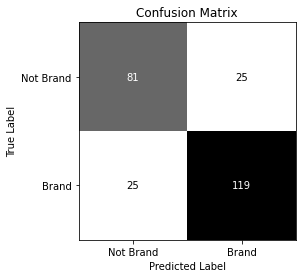

In [27]:
confusion = confusion_matrix(y_val, predictions)
print("Confusion matrix:\n{}".format(confusion))
scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_val, predictions), xlabel="Predicted Label", ylabel="True Label",
        xticklabels=["Not Brand", "Brand"],
        yticklabels=["Not Brand", "Brand"],
        cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion Matrix")
plt.gca().invert_yaxis()

In [28]:
classifier.save_weights(PATHS["classifier"])